In [4]:
import pandas as pd
import csv as csv
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
df = pd.read_csv("train.csv").replace("male", 0).replace("female", 1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [19]:
df["Age"].head(10)

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5    28.0
6    54.0
7     2.0
8    27.0
9    14.0
Name: Age, dtype: float64

In [6]:
#欠損処理 by median
df["Age"].fillna(df.Age.median(), inplace = True)
df["Age"].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

([array([  80.,   97.,  372.]), array([ 216.,  184.,  491.])],
 array([ 1.        ,  1.66666667,  2.33333333,  3.        ]),
 <a list of 2 Lists of Patches objects>)

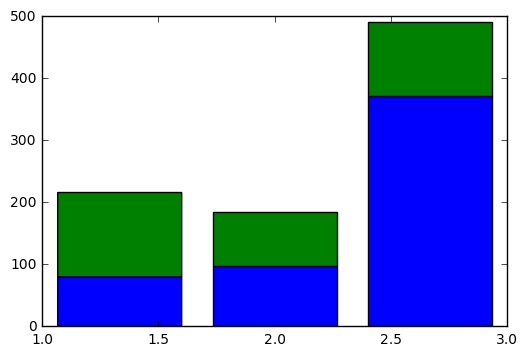

In [7]:
split_data = [] #dataframeをSurvivedが0,1の人で二つのリストに分ける。
for survived in [0, 1]:
    split_data.append(df[df.Survived == survived])
temp = [i["Pclass"].dropna() for i in split_data] #一時的にヒストグラムに居れる変数もSurvivedの0,1で分ける。Split_dataの中をForで回すけど実質二回だけ。
plt.hist(temp, histtype = "barstacked", bins = 3)

In [8]:
split_data[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",0,28.0,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,NaN,S


In [9]:
split_data[1].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,NaN,C


In [10]:
#Familiysizeを親族＋子供の数＋本人で算出。同部屋の可能性などを探る。
df["FamiliySize"] = df["SibSp"] + df["Parch"] + 1

In [11]:
df_dropped = df.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis = 1)#関係ない奴、Familysizeに統合された奴は省いたDf作成。

In [12]:
df_dropped.head()

,PassengerId,Survived,Pclass,Sex,Age,FamiliySize
0,1,0,3,0,22.0,2
1,2,1,1,1,38.0,2
2,3,1,3,1,26.0,1
3,4,1,1,1,35.0,2
4,5,0,3,0,35.0,1


In [13]:
#上の新しいデータフレームでRF試す。
train_df = df_dropped.values #学習用にArrayに変換
x = train_df[:, 2:6] #ArrayのPclass - FamiliySizeを格納
y = train_df[:, 1:2] #Survivedの被説明変数を格納

In [14]:
# データの標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x_std = scaler.transform(x)

In [15]:
rf = RandomForestClassifier(n_estimators = 100)#インスタンス生成
rf = rf.fit(x_std, y)#学習

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [16]:
#テストデータも同じ処理をしてX_testを作成
df_test = pd.read_csv("test.csv").replace("male", 0).replace("female", 1)
#欠損処理 by median
df_test["Age"].fillna(df.Age.median(), inplace = True)
df_test["FamiliySize"] = df_test["SibSp"] + df_test["Parch"] + 1 #Familiysizeを親族＋子供の数＋本人で算出。同部屋の可能性などを探る。
df_test_dropped = df_test.drop(["Name", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], axis = 1)#関係ない奴、Familysizeに統合された奴は省いたDf作成。
test_df = df_test_dropped.values #学習用にArrayに変換
x_test = test_df[:, 1:5] #ArrayのPclass - FamiliySizeを格納

In [17]:
x_test

array([[  3. ,   0. ,  34.5,   1. ],
       [  3. ,   1. ,  47. ,   2. ],
       [  2. ,   0. ,  62. ,   1. ],
       ..., 
       [  3. ,   0. ,  38.5,   1. ],
       [  3. ,   0. ,  28. ,   1. ],
       [  3. ,   0. ,  28. ,   3. ]])

In [18]:
#モデルにX_test入れて予測
output = rf.predict(x_test)
output.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
#予測結果とPassIDをZipする
zip_data = zip(df_test["PassengerId"].astype(int), output.astype(int))
predict_data = list(zip_data)
predict_data[0:10]#予測結果の一部を出力。

In [ ]:
# テスト値を再読み込みして，rfでクラス分類したカラムを追加
df_out = pd.read_csv("./test.csv")
df_out["Survived"] = output

# outputディレクトリに出力する
df_out[["PassengerId","Survived"]].to_csv("./submission_rf.csv",index=False)

In [ ]:
df_out.head()